In [1]:
from pynq import Overlay
import PIL.Image
import numpy as np
import time
import cv2

bareHDMI = Overlay("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.bit")
import pynq_cv.overlays.xv2Filter2DDilate as xv2
from pynq import Xlnk
from pynq.lib.video import *
Xlnk.set_allocator_library("/usr/local/lib/python3.6/dist-packages/pynq_cv/overlays/xv2Filter2DDilate.so")
mem_manager = Xlnk()
hdmi_in = bareHDMI.video.hdmi_in
hdmi_out = bareHDMI.video.hdmi_out

hdmi_in.configure(PIXEL_GRAY)
hdmi_out.configure(hdmi_in.mode)

hdmi_in.cacheable_frames = False
hdmi_out.cacheable_frames = False

hdmi_in.start()
hdmi_out.start()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: pynq.Xlnk is deprecated and will be removed in 2.7 - use pynq.allocate instead
  if sys.path[0] == '':


In [2]:
mymode = hdmi_in.mode
print("HDMI Pic Spec: "+str(mymode))

height = hdmi_in.mode.height
width = hdmi_in.mode.width
bpp = hdmi_in.mode.bits_per_pixel

HDMI Pic Spec: VideoMode: width=1280 height=720 bpp=8


In [3]:
hdmi_in.tie(hdmi_out)

In [4]:
import numpy as np
import time
import cv2

kernelF = np.array([[1.0,0.0,-1.0],[2.0,0.0,-2.0],[1.0,0.0,-1.0]],np.float32)
kernelD = np.ones((3,3),np.uint8)
buf     = np.ones((height,width),np.uint8)

numframes = 20

start = time.time()
for _ in range(numframes):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    cv2.filter2D(inframe, -1, kernelF, dst=buf)
    cv2.dilate(buf, kernelD, dst=outframe, iterations=1)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end = time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  9.361748667542956


In [5]:
kernelF = np.array([[1.0,0.0,-1.0],[2.0,0.0,-2.0],[1.0,0.0,-1.0]],np.float32)
kernelVoid = np.zeros(0)
xFbuf = mem_manager.cma_array((height,width),np.uint8)
numframes = 600
start=time.time()
for _ in range(numframes):
    inframe = hdmi_in.readframe()
    outframe = hdmi_out.newframe()
    xv2.filter2D(inframe, -1, kernelF, dst=xFbuf,borderType=cv2.BORDER_CONSTANT)
    xv2.dilate(xFbuf, kernelVoid, dst=outframe,borderType=cv2.BORDER_CONSTANT)
    inframe.freebuffer()
    hdmi_out.writeframe(outframe)
end=time.time()
print("Frames per second:  " + str(numframes / (end - start)))

Frames per second:  48.903022486764264


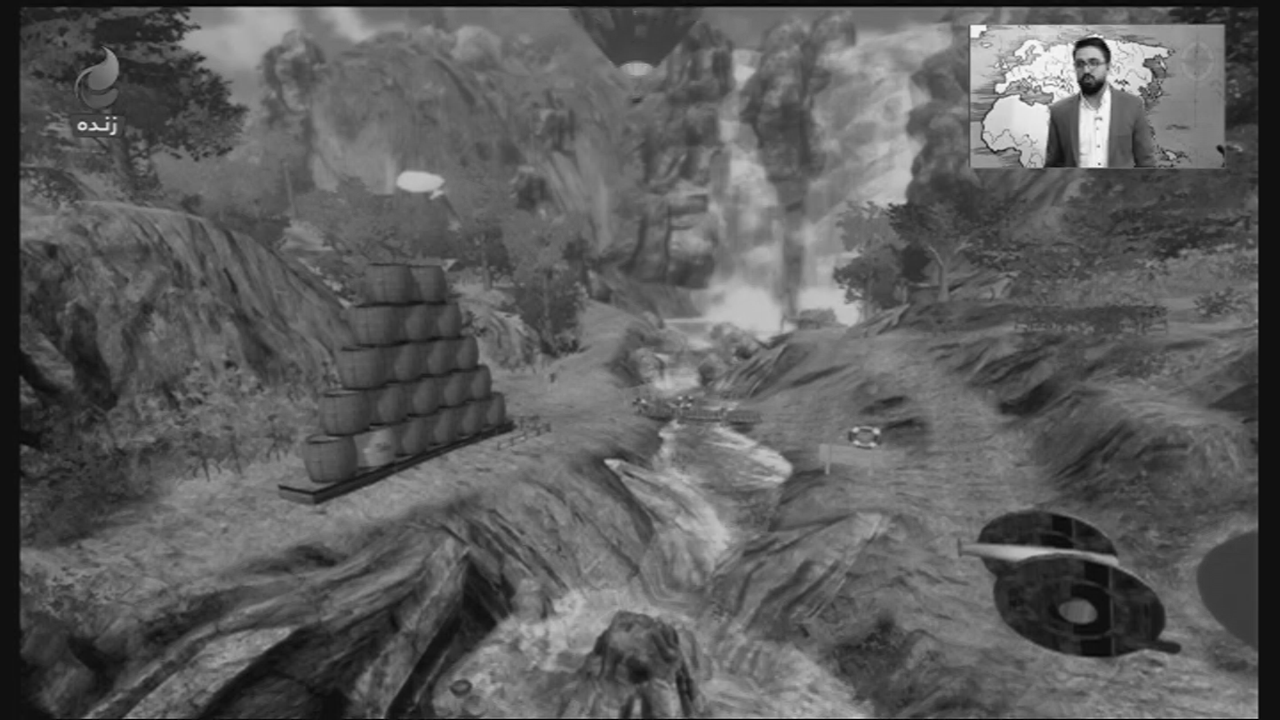

In [6]:
image = PIL.Image.fromarray(inframe)
image

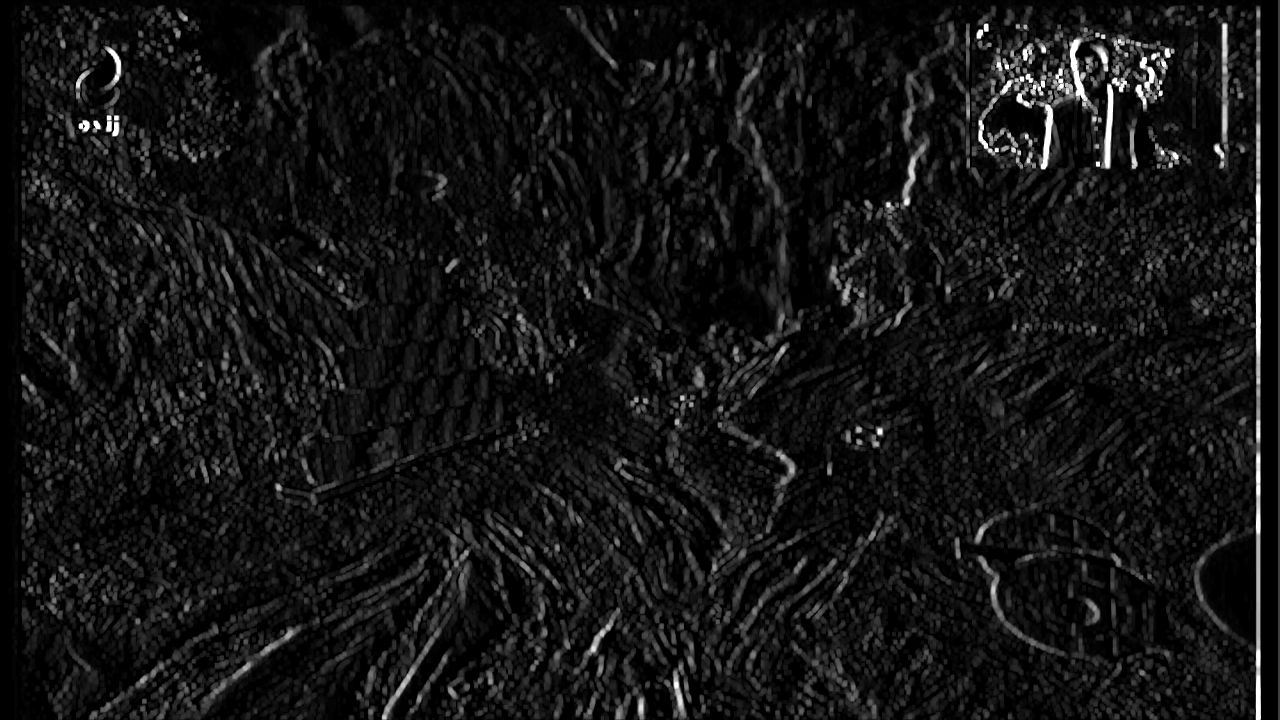

In [7]:
import PIL.Image
image = PIL.Image.fromarray(outframe)
image

In [8]:
hdmi_out.close()
hdmi_in.close()